In [4]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [6]:
def get_data():
    #get train data
    train_data_path ='train.csv'
    train = pd.read_csv(train_data_path)

    #get test data
    test_data_path ='test.csv'
    test = pd.read_csv(test_data_path)

    return train , test

def get_combined_data():
    #reading train data
    train , test = get_data()

    target = train.SalePrice
    train.drop(['SalePrice'],axis = 1 , inplace = True)

    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'Id'], inplace=True, axis=1)
    return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [7]:
combined.describe()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [8]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [9]:

num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [10]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


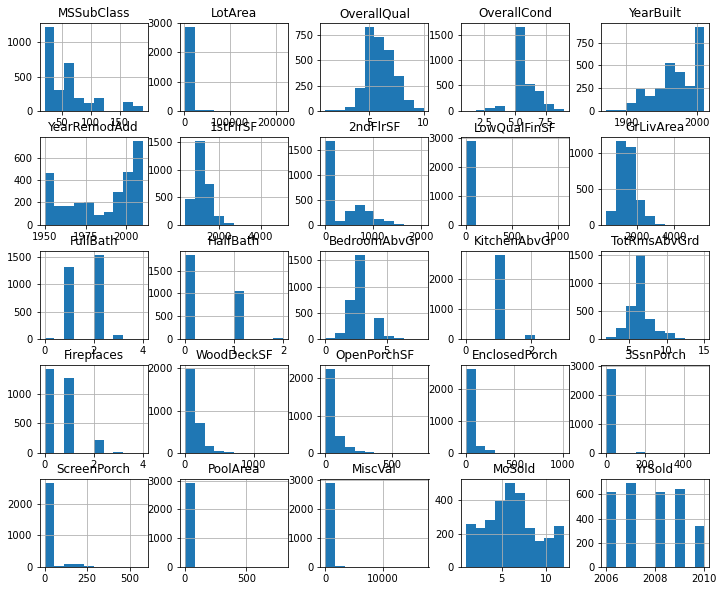

In [11]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

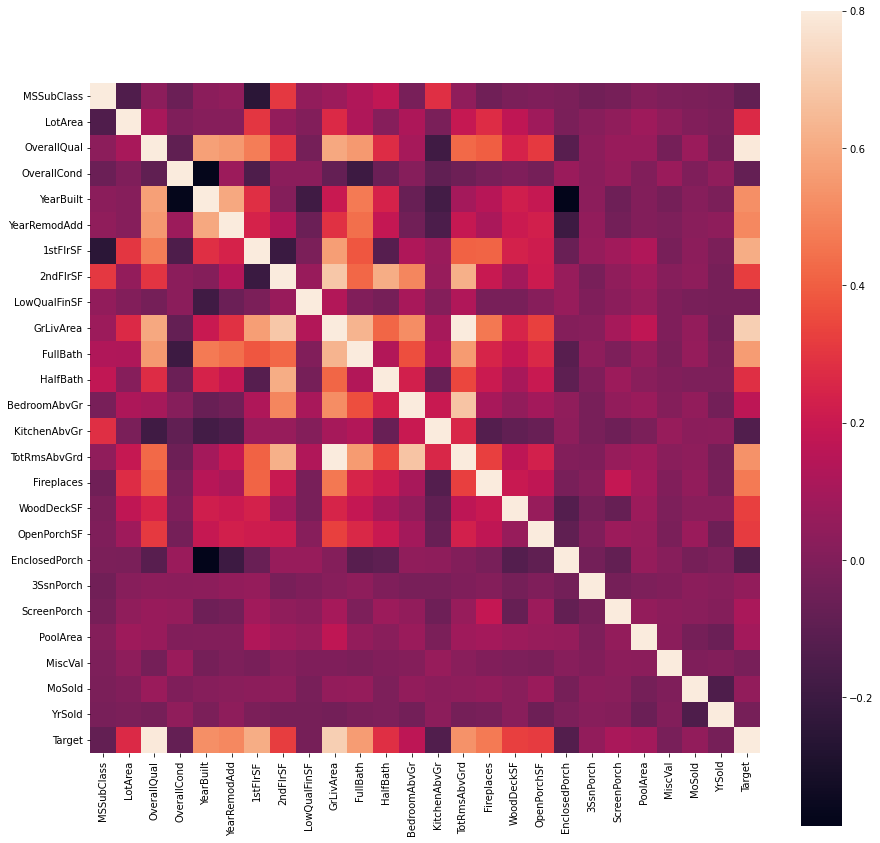

In [12]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [13]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


In [16]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 
  
train, test = split_combined()

In [17]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               19200     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 184,065
Trainable params: 184,065
Non-trainable params: 0
_________________________________________________________________


In [18]:

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [20]:
NN_model.fit(train, target, epochs=20, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)


Epoch 1/20
37/37 [==============================] - 0s 3ms/step - loss: 26485.0078 - mean_absolute_error: 26485.0078 - val_loss: 32411.0312 - val_mean_absolute_error: 32411.0312

Epoch 00001: val_loss did not improve from 30975.18164
Epoch 2/20
37/37 [==============================] - 0s 3ms/step - loss: 27249.9902 - mean_absolute_error: 27249.9902 - val_loss: 32974.2930 - val_mean_absolute_error: 32974.2930

Epoch 00002: val_loss did not improve from 30975.18164
Epoch 3/20
37/37 [==============================] - 0s 3ms/step - loss: 27182.7422 - mean_absolute_error: 27182.7422 - val_loss: 31318.5176 - val_mean_absolute_error: 31318.5176

Epoch 00003: val_loss did not improve from 30975.18164
Epoch 4/20
37/37 [==============================] - 0s 3ms/step - loss: 27068.3750 - mean_absolute_error: 27068.3750 - val_loss: 33947.2930 - val_mean_absolute_error: 33947.2930

Epoch 00004: val_loss did not improve from 30975.18164
Epoch 5/20
37/37 [==============================] - 0s 3ms/step 

In [24]:
wights_file = 'Weights-020--27778.42969.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [27]:
def make_submission(prediction, sub_name):
    my_submission = pd.DataFrame({'Id':pd.read_csv('test.csv').Id,'SalePrice':prediction})
    my_submission.to_csv('{}.csv'.format(sub_name),index=False)
    print('A submission file has been made')

predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission(NN).csv')

A submission file has been made


In [28]:
predictions

array([[111521.41],
       [119675.36],
       [177961.22],
       ...,
       [143673.72],
       [116915.43],
       [211886.08]], dtype=float32)

In [ ]:
test